In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re
import nltk
#import spacy
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS #get_ipython().system('pip install wordcloud')
import seaborn as sns
from sklearn.model_selection import train_test_split

In [70]:
tweet_input = pd.read_csv("covid19_tweets.csv")
pd.options.mode.chained_assignment = None 

### Filter tweet by hashtag count>100

In [71]:
tweet= tweet_input['text']
def convert(lst):
    return ([i for item in lst for i in item.split()])
panda_df = pd.DataFrame(data =tweet_input, columns = ["text","hashtags"])
panda_df=panda_df[panda_df['hashtags'].notnull()]
df = pd.DataFrame(convert(panda_df['hashtags']))
df=df.replace(',','', regex=True)
df=df.replace("]",'', regex=True)
df=df.replace('\'','', regex=True)
df=df.replace('\[''', '', regex=True)
df.columns=['Words']
s=df.value_counts()
Words=pd.DataFrame(s.nlargest(155))
modified = Words.reset_index()
modified.columns=['Words',"Counts"]
#print(modified) ## Mention count above 100
selection = modified['Words'].tolist()
filtered_tweet=tweet_input[tweet_input['hashtags'].notnull()]
## Hashtags which contains these top 100 words
mask = filtered_tweet.hashtags.apply(lambda x: any(item for item in selection if item in x))
filtered_tweet=filtered_tweet[mask]

In [72]:
data = filtered_tweet[['user_name','date','text','hashtags']]
data

,user_name,date,text,hashtags
2,Time4fisticuffs,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19']
3,ethel mertz,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19']
4,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']"
5,🎹 Franz Schubert,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']"
6,hr bartender,2020-07-25 12:27:03,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']"
...,...,...,...,...
179101,New Jersey Herald,2020-08-29 19:44:27,Wallkill school nurse adds COVID-19 monitoring...,"['nurses', 'COVID19', 'coronavirus', 'schools']"
179102,Pris,2020-08-29 19:44:23,"we have reached 25mil cases of #covid19, world...",['covid19']
179103,AJIMATI AbdulRahman O.,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask']
179104,Jason,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19']


In [73]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # prevent showing future warning
tweet= data.loc[:,'text']
##remove website
tweet= tweet.str.replace(r'http://[^\s<>"]+|www\.[^\s<>"]+', "") ##Ref https://stackoverflow.com/questions/10475027/extracting-url-link-using-regular-expression-re-string-matching-python
##remove mentions and the word followed 
tweet = tweet.str.replace(r'\s*@\s\w+', '', regex=True)
#remove hashtags
tweet = tweet.str.replace(r'\W*#\W+', '', regex=True)
##remove punctuation
tweet = tweet.str.replace('[^\w\s]','')
##remove numbers
tweet = tweet.str.replace('\S*\d\S*', '')
##remove underscore
tweet = tweet.str.replace(r"\W+_\W+", '', regex=True)
tweet = tweet.str.replace(r"_", '', regex=True)
##remove brackets
tweet = tweet.str.replace('\[.*?\]', '')
##convert to lower case
tweet= tweet.str.lower()
##drop empty rows
tweet.dropna(inplace=True)
##remove leading and ending white space
tweet = tweet.str.strip()
data.loc[:,'text'] =tweet

### Sentiment Analyze using NLTK(nlp) 

In [74]:
# ref NLTK sentiment analyse https://www.nltk.org/howto/sentiment.html
get_ipython().system('pip install vaderSentiment')
sentiment_analyzer = SentimentIntensityAnalyzer()
scores=[]
sentiment_=[]
for i in data['text']:
    sentiment_score = sentiment_analyzer.polarity_scores(i)
    score = sentiment_score['compound']
    scores.append(score)
data=data.assign(sentiment_score = scores)

for i in data['sentiment_score']:
    if i>0:
        sentiment='positive'
    elif i==0:
        sentiment='neutral'
    else:
        sentiment='negative'
    sentiment_.append(sentiment)
data=data.assign(sentiments=sentiment_)


### WordCloud

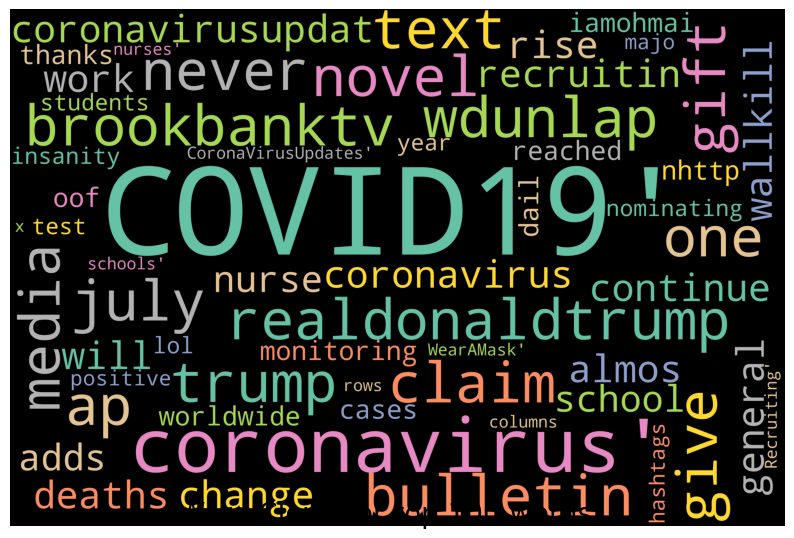

In [75]:
df_wordcloud=data[['text','hashtags']]
word_cloud = WordCloud(background_color='black',colormap='Set2',stopwords=set(STOPWORDS),max_words=100,width = 3000, height = 2000,random_state=1,collocations=False).generate(str(df_wordcloud))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 100 words', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

(array([18468., 18472., 18475., 18479., 18483., 18487., 18491., 18495.,
        18499., 18503.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

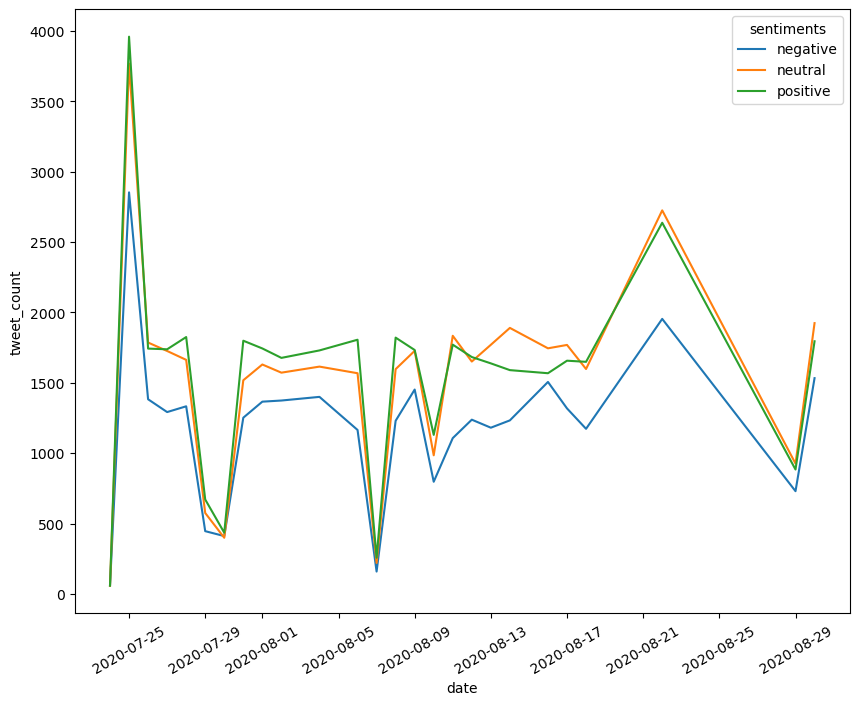

In [60]:
data_agg=data[['date','sentiments','text']]
data_agg['date'] =  pd.to_datetime(data_agg['date']).dt.date 
groups=data_agg.groupby(['date','sentiments'])
data_agg =groups.aggregate('count').reset_index()
data_agg=data_agg.rename(columns={'text': 'tweet_count'})

sns.lineplot(data=data_agg, x="date", y="tweet_count", hue="sentiments")
plt.xticks(rotation = 30)

([<matplotlib.patches.Wedge at 0x7f9598c48520>,
 [Text(0.7121726395525068, 0.8383377192234734, 'Negative'),
  Text(-1.0566873292628787, 0.3056335848287702, 'Netural'),
  Text(0.45119967458126176, -1.0032042930818048, 'Positive')],
 [Text(0.38845780339227637, 0.45727511957644, '28%'),
  Text(-0.576374906870661, 0.16670922808842006, '36%'),
  Text(0.24610891340796093, -0.5472023416809844, '37%')])

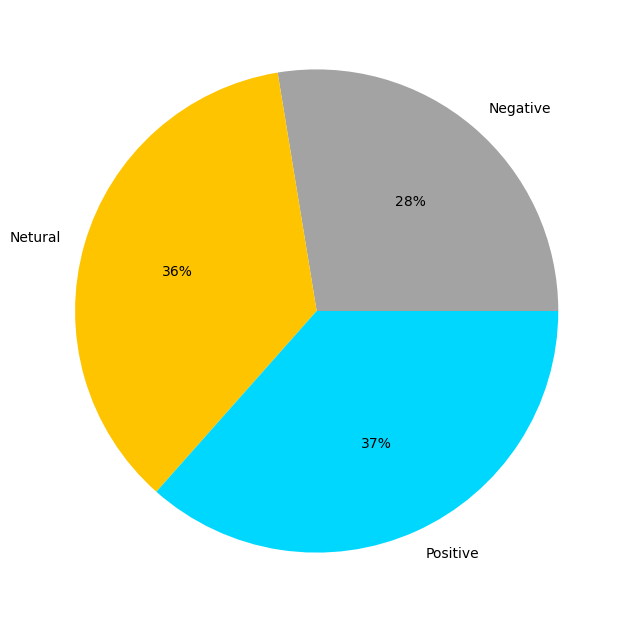

In [67]:
#data_agg.groupby('sentiments').sum() to get the count numbers
data_sum=[30945,40239,40999]
data_lable=['Negative', 'Netural', 'Positive']
colors = sns.color_palette('bright')[7:10]
plt.pie(data_sum,labels = data_lable, colors = colors, autopct='%.0f%%')

In [ ]:
## separate training and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

-0.8725


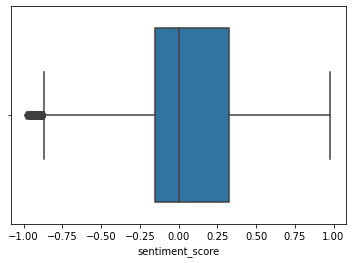

In [27]:
#use boxplot to check outlier
import seaborn as sns
sns.boxplot(x=data['sentiment_score']) 
Q1 = data['sentiment_score'].quantile(0.25)
Q3 = data['sentiment_score'].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
print(Lower_Fence)

#remove outlier
data=data.loc[data['sentiment_score']>= -0.8725]

fit.slope: -6.4749401707802155e-09
fit.intercept 10.377499389871739
fit.pvalue 6.42417954662732e-07


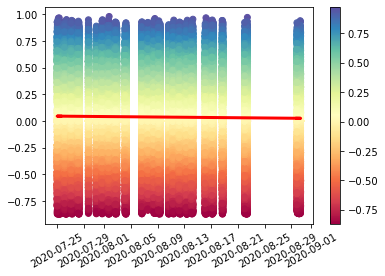

In [28]:
data['date'] =  pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

def to_timestamp(t):
    return datetime.timestamp(t)
data['timestamp'] = data['date'].apply(to_timestamp)
fit = stats.linregress(data['timestamp'] , data['sentiment_score'])
data['prediction'] = data['timestamp']*fit.slope + fit.intercept
print("fit.slope:",fit.slope)
#fit.slope<0, so the sentimen_score has a slight decrease during the period
print("fit.intercept",fit.intercept)
print("fit.pvalue", fit.pvalue) 
##since p value<0.05, reject H0, the ratings has been changing over time
plt.xticks(rotation = 30)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(data['date'] , data['sentiment_score'], c=data['sentiment_score'], cmap='Spectral')
plt.colorbar()
#plt.plot(data['date'] , data['sentiment_score'] , 'b.' , alpha = 0.5)
plt.plot(data['date'] , data['timestamp']*fit.slope + fit.intercept , 'r-' , linewidth =3)

(array([ 4016.,  8483.,  8249.,  7177., 44222.,  6939., 11907., 12311.,
         6657.,  2222.]),
 array([-0.91765998, -0.73186335, -0.54606672, -0.36027009, -0.17447345,
         0.01132318,  0.19711981,  0.38291644,  0.56871307,  0.7545097 ,
         0.94030634]),
 <BarContainer object of 10 artists>)

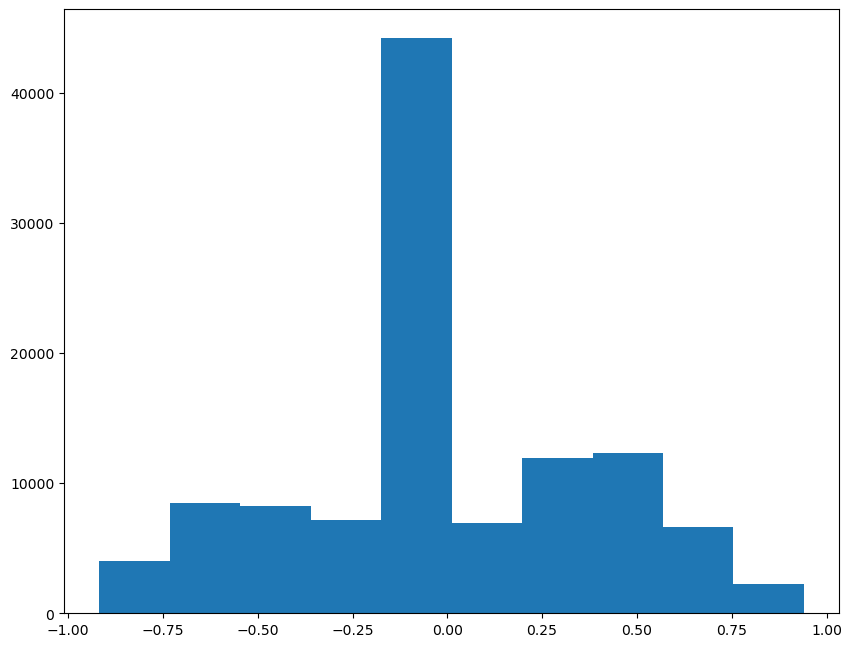

In [29]:
residuals=data['sentiment_score']-data['prediction']
plt.hist(residuals)#the requirement of normality can be softened with kind-of-normal data and n>=40

In [ ]:
# corr_matrix = np.corrcoef(positive_tweet['sentiment_score'], positive_tweet['prediction'])
# corr = corr_matrix[0,1]
# R_sq = corr**2
# print("corr_matrix:")
# print(corr_matrix)
# print("R-square:",R_sq)
# print(stats.linregress(data['timestamp'], data['sentiment_score']).rvalue)

In [80]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

In [ ]:

data_raw = "读入的数据".split('\n') # 按行分隔
data_blue = []
data_red = []
word_count_blue = {}
word_count_red = {}
for line_data in data_raw:
    word_list = line_data.split(" ") # 分隔单词
    if word_list[0] == "BLUE":
        for i in range(1,len(word_list)):
            if not is_excluded(word_list[i]): # 判断是否为停用词
                data_blue.append(word_list[i])
                # 统计单词出现次数
                word_count_blue.setdefault(word_list[i], 0)
                word_count_blue[word_list[i]] += 1
    elif word_list[0] == "RED":